# OAI 3T Data Preparation (new) 
Updated: 27 Mar 2023 - New slice selection method: thresholding
- Combine all masks in 2Dtrain and 2Dvalid into single class label (`LABELS_SINGLE`)
- For each image subject, find the max label amount, extract the 5 slices before and 5 slices after => export that list
- Save list in dataset list for training

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pandas
from PIL import Image
from sklearn.model_selection import train_test_split
import json
import random
import math
import pickle

## 1. Combine all masks into single class (2Dtrain and 2Dvalid) 

In [2]:
def combine_masks(label_path, new_label_path):
    for filename in os.listdir(label_path):
        if filename not in os.listdir(new_label_path):
            with h5py.File(os.path.join(label_path, filename)) as hf:
                label = np.array(hf['data'])
                hf.close()

    #         name, extension = os.path.splitext(filename)
            new_label = np.zeros((label.shape[0], label.shape[1]))

            for num in range(4): # exclude meniscus (5 and 6)
                for i in range(label.shape[0]): # row
                    for j in range(label.shape[1]): #col
                        if label[i, j, num] != 0:
                            new_label[i, j] = label[i, j, num]

            new_labelh5f = h5py.File(os.path.join(new_label_path, filename), 'w')
            new_labelh5f.create_dataset("data", data=new_label)
            new_labelh5f.close()

            print(filename, 'done')
            print(new_label.shape)

In [3]:
label_path = 'OAIdataset/2Dtrain/LABELS'
new_label_path = 'OAIdataset/2Dtrain/LABELS_SINGLE'

print(len(os.listdir(new_label_path)))
# combine_masks(label_path, new_label_path)

19200


In [8]:
label_path = 'OAIdataset/2Dvalid/LABELS'
new_label_path = 'OAIdataset/2Dvalid/LABELS_SINGLE'

print(len(os.listdir(label_path)))
# combine_masks(label_path, new_label_path)

4480


In [5]:
print(len(os.listdir(label_path)))
for filename in os.listdir(label_path):
    if "ipynb_checkpoints" in filename:
        print(filename)

4480


In [9]:
remove_path = label_path+'/.ipynb_checkpoints'
if shutil.os.path.exists(remove_path):
    shutil.rmtree(remove_path)
    print('removed')

removed


## 2. Extract slices 
- For each image subject, get the index of label slice with the max amount of 1
- Display it 
- Get 5 slices before and after => save it into list 

In [13]:
# idx_max = 60, view_max = 2
def slice_extract(label_filepath, image_filepath, idx_max, view_max, torv):
    fileList = os.listdir(label_filepath)
    
    extractedList = []
    
    for idx in range(1, idx_max+1):
        for view in range(view_max):
            
            prefix = torv+'_'+str(idx).zfill(3)+'_V'+str(view).zfill(2)
            subj_labels = [f for f in fileList if f.startswith(prefix)] # store the list of label files for each 3D image
            print(len(subj_labels)) # should be 160
            
            # find the index of the label with most cartilage in it
            max_ones = 0
            max_slice_idx = 0
            for label in subj_labels:
                
                with h5py.File(os.path.join(label_filepath, label)) as hf:
                    lbarray = np.array(hf['data'])
                    hf.close()
                    
                num_ones = np.count_nonzero(lbarray) # count number of nonzeros in the label
                if num_ones >= max_ones:
                    max_ones = num_ones # replace max number of ones

                    name, extension = os.path.splitext(label)
                    max_slice_idx = int(name[-3:]) # save the slice index
                
            print('Max slice: ', max_slice_idx, ' with ', max_ones)
            print('filename: ', prefix+'_'+str(max_slice_idx).zfill(3))
            print()
            # extract the 4 slices before and 6 slices after this max slice => total 10 slices
            for i in range(max_slice_idx-4, max_slice_idx+6):
                onlyname = prefix+'_'+str(i).zfill(3)
                
                imgInfo = {
                    "image": os.path.join(image_filepath, onlyname+'.im'), 
                    "label": os.path.join(label_filepath, onlyname+'.seg')
                  }
                
                extractedList.append(imgInfo)
    
    return extractedList

### 2.1. Train dataset

In [2]:
### Uncomment to extract slices

# img_path = 'OAIdataset/2Dtrain/IMAGES'
# label_path = 'OAIdataset/2Dtrain/LABELS_SINGLE'
# train_extracted = slice_extract(label_path, img_path, 60, 2, 'train')

0.017532617
1.0


/rds/general/user/dlc19/home/anaconda3/envs/dlcpytorch/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


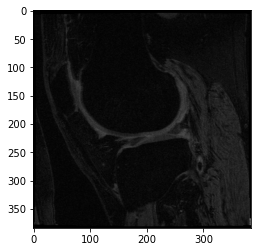

In [67]:
with h5py.File('OAIdataset/2Dtrain_slices/IMAGES/train_046_V01_045.im') as hf:
    imarray = np.array(hf['data'])
    hf.close()
    print(np.max(imarray))

# plt.imshow(imarray, cmap='gray')
normimarray = (imarray - np.min(imarray)) / (np.max(imarray) - np.min(imarray))
print(np.max(normimarray))
PILimage = Image.fromarray((normimarray * 255).astype(np.uint8))
plt.imshow(PILimage, cmap = 'gray')

1200
{'image': 'OAIdataset/2Dtrain/IMAGES/train_001_V00_099.im', 'label': 'OAIdataset/2Dtrain/LABELS_SINGLE/train_001_V00_099.seg'}


/rds/general/user/dlc19/home/anaconda3/envs/dlcpytorch/lib/python3.7/site-packages/ipykernel_launcher.py:10: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # Remove the CWD from sys.path while we load stuff.


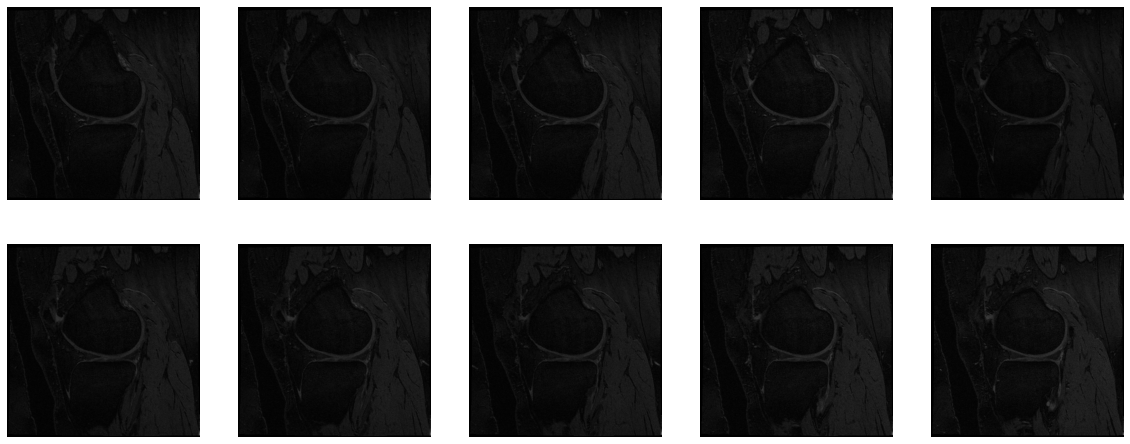

In [68]:
print(len(train_extracted))
print(train_extracted[0])

nrows = 2
ncols = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
# axes = axes.flatten()

for i in range(nrows*ncols):
    with h5py.File(train_extracted[i]['image']) as hf:
        imarray = np.array(hf['data'])
        hf.close()
    
#     normimarray = (imarray - np.min(imarray)) / (np.max(imarray) - np.min(imarray))
#     PILimage = Image.fromarray((normimarray * 255).astype(np.uint8))
    axes[i // ncols, i % ncols].imshow(imarray, cmap='gray')
    axes[i // ncols, i % ncols].axis("off")
#     axes[i // ncols, i % ncols].set_title('Slice '+str(i), fontsize=15)

In [24]:
with open("OAIdataset/train_extracted.pkl", "wb") as f:
    pickle.dump(train_extracted, f)

### 2.2. Valid dataset

In [3]:
### Uncomment to extract slice

# img_path = 'OAIdataset/2Dvalid/IMAGES'
# label_path = 'OAIdataset/2Dvalid/LABELS_SINGLE'
# valid_extracted = slice_extract(label_path, img_path, 14, 2, 'valid')

In [74]:
print(len(valid_extracted))
print(len(train_extracted))

280
1200


In [5]:
with open("OAIdataset/valid_extracted.pkl", "wb") as f:
    pickle.dump(valid_extracted, f)

Save for future use

In [77]:
all_extracted = train_extracted + valid_extracted
print(len(all_extracted))

with open("OAIdataset/all_extracted.pkl", "wb") as f:
    pickle.dump(all_extracted, f)
    
    

1480


/rds/general/user/dlc19/home/anaconda3/envs/dlcpytorch/lib/python3.7/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if __name__ == '__main__':


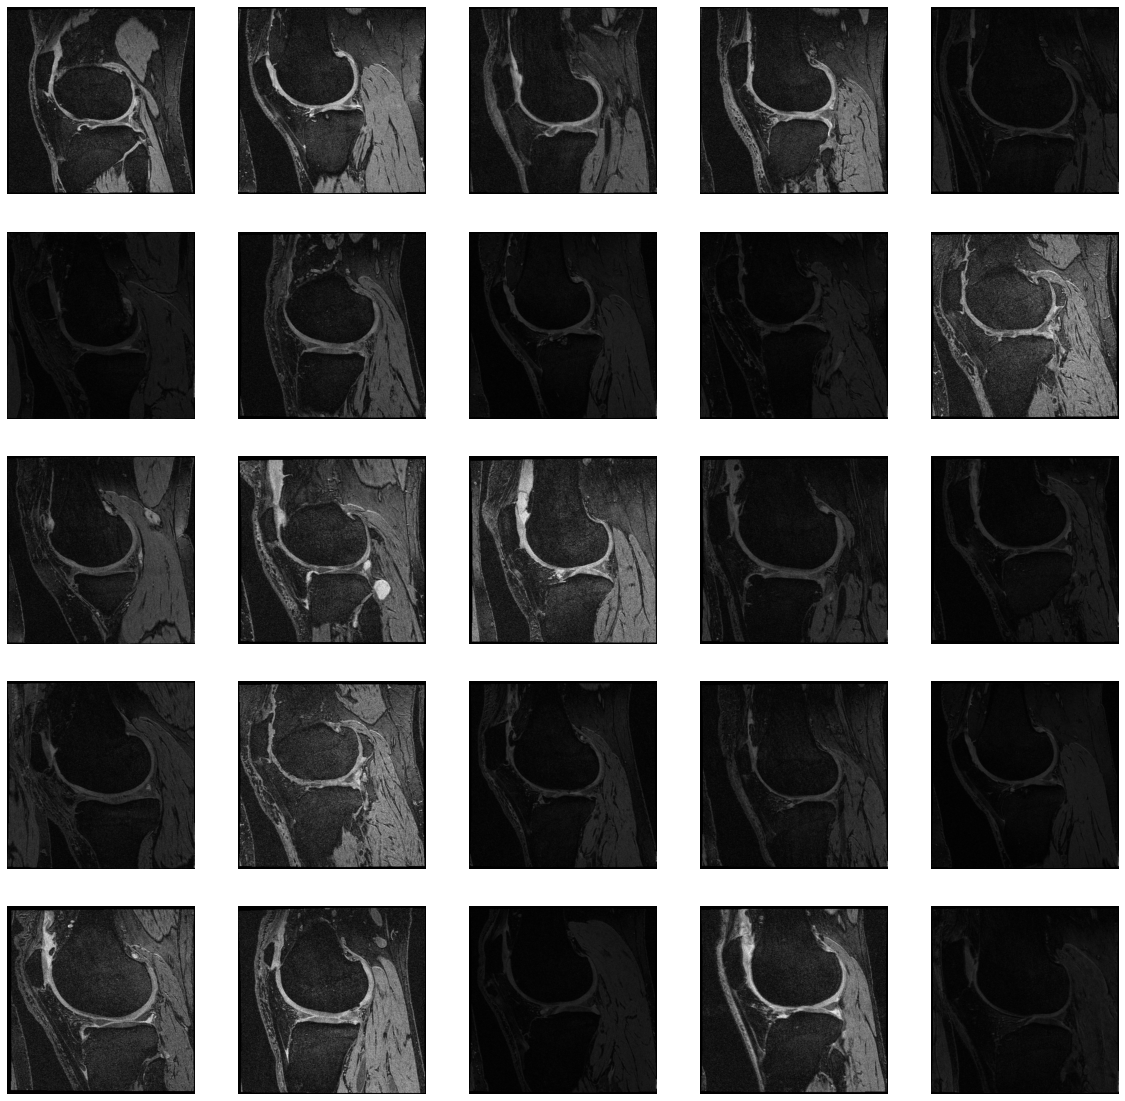

In [90]:
nrows = 5
ncols = 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
# axes = axes.flatten()

for i in range(nrows*ncols):
    rand = random.randint(1, len(all_extracted)-1)
    with h5py.File(all_extracted[rand]['image']) as hf:
        imarray = np.array(hf['data'])
        hf.close()
    
    normimarray = (imarray - np.min(imarray)) / (np.max(imarray) - np.min(imarray))
    PILimage = Image.fromarray((normimarray * 255).astype(np.uint8))
    axes[i // ncols, i % ncols].imshow(PILimage, cmap='gray')
    axes[i // ncols, i % ncols].axis("off")
#     axes[i // ncols, i % ncols].set_title('Slice '+str(i), fontsize=15)

In [89]:
# def load_dataset(jsonfile):
#     f = open(jsonfile)
#     dataset = json.load(f)
#     train_dataset = dataset['train']
#     test_dataset = dataset['test']
#     return train_dataset, test_dataset

# train_list, test_list = load_dataset('3TMRIslices_dataset.json')


# nrows = 10
# ncols = 5
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))
# # axes = axes.flatten()

# for i in range(nrows*ncols):
#     rand = random.randint(1, len(train_list)-1)
# #     print(all_extracted[rand]['image'])
#     with h5py.File(train_list[rand]['image']) as hf:
#         imarray = np.array(hf['data'])
#         hf.close()
    
#     normimarray = (imarray - np.min(imarray)) / (np.max(imarray) - np.min(imarray))
#     PILimage = Image.fromarray((normimarray * 255).astype(np.uint8))
#     axes[i // ncols, i % ncols].imshow(PILimage, cmap='gray')
#     axes[i // ncols, i % ncols].axis("off")
# #     axes[i // ncols, i % ncols].set_title('Slice '+str(i), fontsize=15)

## 3. Make dataset `json` file

In [2]:
with open('OAIdataset/all_extracted.pkl', 'rb') as f:
    all_extracted = pickle.load(f)
    
len(all_extracted)

1480

In [6]:
def train_valid_test(data_list, portion):
    
    datasetDict = {}
    datasetDict["name"] = "OAIChallengeDataset (labelled) for segmentation test"
    datasetDict['date'] = '27/05/2023'
    datasetDict["description"] = "Contains extracted 2D images slices from OAI Challenge Dataset for cartilage segmentation (for data efficiency)"
    datasetDict["labels"] = {
        "0": "background", 
        "1": "cartilage"
    }      
    
    # train-valid-test split on all_data
    train_data, test_data = train_test_split(data_list, test_size=0.1, random_state=42)
    
    # portion of dataset used
    train_data = random.sample(train_data, math.floor(len(train_data)*portion))
#     train_data = all_data[:math.floor(len(train_data)*portion)]
    
    datasetDict["numTrain"] = len(train_data)
    datasetDict["numTest"] = len(test_data)
    
    datasetDict["train"] = train_data
    datasetDict["test"] = test_data
    
    return datasetDict 

In [ ]:
jsonDict = train_valid_test(all_extracted, 1.0)

nolabel_out_file = open('OAIdataset/3TMRI_dataset_1.json', "w")
json.dump(jsonDict, nolabel_out_file, indent = 8)
nolabel_out_file.close()